In [ ]:
import numpy as np 
import pandas as pd 
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Input, Masking, Activation, Dropout, Concatenate
from tensorflow.keras.layers import Flatten, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.utils import to_categorical
from keras.regularizers import l1, l2

In [ ]:
mode = 'training'
# mode = 'submission'
# mode = 'inference_testing'

In [ ]:
## loading train.csv data

train_df = pd.read_csv('/kaggle/input/asl-signs/train.csv')
train_df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [ ]:
## loading sign index map 

json_file = open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json')
sign_label = json.load(json_file)  ## a dictionary variable with all labels and its integer representation
n_signs = len(sign_label)
n_signs  ## number of classes

250

In [ ]:
## understanding parquet data for one sign example given

pq_path = os.path.join('/kaggle/input/asl-signs',train_df['path'][0])   ## taking first data in df
pq_df = pd.read_parquet(pq_path)
pq_df

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [ ]:
pq_df[pq_df['frame']==20].groupby('type')['landmark_index'].count()  ## for one frame finding the landmark data

type
face          468
left_hand      21
pose           33
right_hand     21
Name: landmark_index, dtype: int64

Order is face, left_hand, pose, right_hand

For each type, the index starts from 0. Thus, should calculate for each type and get only required index

0 - 468 --> face landmarks

468 - 489 --> left hand landmarks

489 - 522 --> pose landmarks

522 - 543 --> right hand landmarks

In [ ]:
del pq_df

As seen, the most videos have between 1 and 300 frames, the counts of frames after 300 are very less almost 1 video per frame number only. But 50 is where max videos have frames 
Hence, considering max_frames as 30. 

### Understanding landmarks in Mediapipeline holistic data

In [ ]:
pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 29.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import mediapipe as mp

lips_indices = set()

for ele in mp.solutions.face_mesh_connections.FACEMESH_LIPS:
    lips_indices.add(ele[0])
    lips_indices.add(ele[1])

In [ ]:
np.array(lips_indices)

array({0, 267, 13, 14, 269, 270, 17, 146, 402, 405, 409, 415, 291, 37, 39, 40, 178, 308, 181, 310, 311, 312, 185, 314, 61, 317, 191, 318, 321, 324, 78, 80, 81, 82, 84, 87, 88, 91, 95, 375},
      dtype=object)

In [ ]:
left_hand_indices = [i for i in range(468,489)]
right_hand_indices = [i for i in range(522,543)]
np.array(left_hand_indices), np.array(right_hand_indices)

(array([468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480,
        481, 482, 483, 484, 485, 486, 487, 488]),
 array([522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
        535, 536, 537, 538, 539, 540, 541, 542]))

In 0 - 468 of face landmarks, only the lip and outline indices are taken and only hand landmarks are taken. Pose is not taken. 

In [ ]:
reqd_keypoints = list(lips_indices) + list(left_hand_indices) + list(right_hand_indices)

In [ ]:
ROWS_PER_FRAME = 543    ## number of landmark indexes for each frame
MAX_LENGTH = 30
N_KEYPTS = len(reqd_keypoints)  ## 82
N_KEYPTS

82

## Creating Dataset for training and validation

In [ ]:
## the way data will be loaded for evaluation, using same for training
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)   ## (n_frames, ROWS_PER_FRAME, 3)  ## (n_frames, 543, 3)

In [ ]:
def create_dataset(file_path_list, labels_list):
    x_data = np.empty(shape=(len(file_path_list), MAX_LENGTH, N_KEYPTS*3)) 
    y_data = []

    for i in tqdm(range(len(file_path_list))):
        pq_path = os.path.join('/kaggle/input/asl-signs', file_path_list[i])
        video_keypoints = load_relevant_data_subset(pq_path)  ## gives a numpy array of shape (n_frames, 543, 3)
        video_keypoints = video_keypoints[:, reqd_keypoints]   ## keeping only required keypoints
        video_keypoints[np.isnan(video_keypoints)] = 0        ## converting all nan to 0 in the numpy array
           
            
        if video_keypoints.shape[0] < MAX_LENGTH:
            diff = MAX_LENGTH - video_keypoints.shape[0]
            video_keypoints = np.append(np.zeros((diff, N_KEYPTS, 3)), video_keypoints, axis=0)
        else:
            video_keypoints = video_keypoints[-(MAX_LENGTH):]
            
        x = np.concatenate([video_keypoints[...,i] for i in range(3)], -1)
        
        del video_keypoints
        
        x_data[i] = x

        y_data.append(sign_label[labels_list[i]])
        
    x_data = np.asarray(x_data).astype(np.float32)
    y_data = np.asarray(y_data).astype(np.int)
        
    
    return x_data, y_data   ## this gives a x_data with max_length arrays

The shape of data when giving input should be same, but here it will be different. Thus, will be using padding command to make the length equal for all arrays. 

In [ ]:
## splitting data for training and validation  ## taking only 10,000 rows of data
if mode == 'training':
#     train_data, val_data = train_test_split(train_df.sample(10000), test_size=0.05, random_state=11)
    train_data, val_data = train_test_split(train_df, test_size=0.05, random_state=21)

In [ ]:
# getting training data in the form required for model 
if mode == 'training':

    x_train, y_train = create_dataset(list(train_data['path']), list(train_data['sign']))

100%|██████████| 89753/89753 [32:28<00:00, 46.07it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
# getting validation data in the form required for model 
if mode == 'training':

    x_val, y_val = create_dataset(list(val_data['path']), list(val_data['sign']))

100%|██████████| 4724/4724 [01:42<00:00, 45.86it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((89753, 30, 246), (89753,), (4724, 30, 246), (4724,))

## Building Model and training

In [ ]:
# # Define model input shape
input_shape = (None, N_KEYPTS*3)

# Define input layer
inputs = Input(shape=input_shape)

# Define transformer layer
transformer_layer = MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.3)
transformer_output = transformer_layer(inputs, inputs)

# Add layer normalization and residual connection
transformer_output = LayerNormalization()(inputs + transformer_output)

# Define LSTM layer
lstm_output1 = LSTM(128, return_sequences=True)(transformer_output)
dropout_output1 = Dropout(0.3)(lstm_output1)  ## dropout layer

# Define LSTM layer
lstm_output2 = LSTM(128)(dropout_output1)
dropout_output2 = Dropout(0.3)(lstm_output2)  ## dropout layer

## Adding dense layers 
dense_output = Dense(64)(dropout_output2)
dense_output2 = Dense(32)(dense_output)

# Define output layer
output = Dense(n_signs, activation='softmax')(dense_output2)

# Create model
transformer_lstm_model = Model(inputs=inputs, outputs=output)

In [ ]:
## compiling the model

transformer_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

In [ ]:
## model summary
transformer_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 246)]  0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, None, 246)   505590      ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, None, 246)   0           ['input_1[0][0]',                
 da)                                                              'multi_head_attention[0][0]']   
                                                                                              

In [ ]:
# creating a folder to save model weights 


folder_path ='/kaggle/working/Transformer_LSTM/'

if os.path.exists(folder_path) == True:
    None
else:
    os.makedirs(folder_path)

In [ ]:
# enforciong early stopping, saving weights and optimizing learning rate

checkpoint_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True), 
                   tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/Transformer_LSTM/weights_epoch_{epoch:02d}.hdf5', save_weights_only=True, monitor='val_accuracy', 
                                                      mode='max', save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 5)]

In [ ]:
EPOCHS = 20
BATCH_SIZE = 256
STEPS_PER_EPOCH = len(train_data['path'])//BATCH_SIZE
VAL_STEPS = len(val_data['path'])//BATCH_SIZE

In [ ]:
STEPS_PER_EPOCH, VAL_STEPS

(350, 18)

In [ ]:
EPOCHS = 150

if mode == 'training':
    history = transformer_lstm_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, 
                                     validation_data=(x_val, y_val), validation_steps=VAL_STEPS, callbacks=checkpoint_list)

Epoch 1/150
350/350 [==============================] - 21s 29ms/step - loss: 5.2603 - accuracy: 0.0137 - sparse_top_k_categorical_accuracy: 0.0606 - val_loss: 4.8568 - val_accuracy: 0.0319 - val_sparse_top_k_categorical_accuracy: 0.1241 - lr: 0.0010
Epoch 2/150
350/350 [==============================] - 9s 25ms/step - loss: 4.5731 - accuracy: 0.0558 - sparse_top_k_categorical_accuracy: 0.1996 - val_loss: 4.1634 - val_accuracy: 0.0994 - val_sparse_top_k_categorical_accuracy: 0.3077 - lr: 0.0010
Epoch 3/150
350/350 [==============================] - 9s 26ms/step - loss: 4.0750 - accuracy: 0.1071 - sparse_top_k_categorical_accuracy: 0.3324 - val_loss: 3.8781 - val_accuracy: 0.1374 - val_sparse_top_k_categorical_accuracy: 0.3822 - lr: 0.0010
Epoch 4/150
350/350 [==============================] - 9s 26ms/step - loss: 3.8000 - accuracy: 0.1478 - sparse_top_k_categorical_accuracy: 0.4085 - val_loss: 3.6831 - val_accuracy: 0.1656 - val_sparse_top_k_categorical_accuracy: 0.4368 - lr: 0.0010
Epo

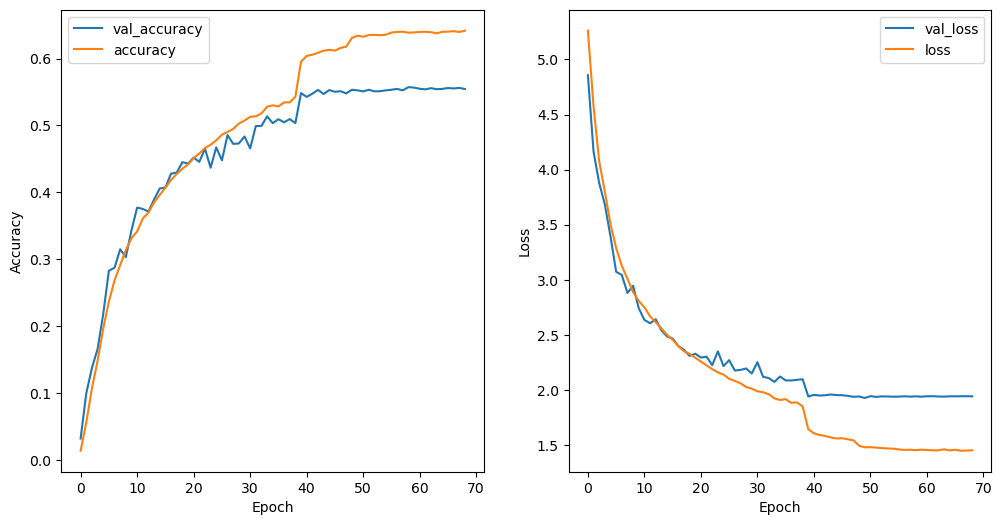

In [ ]:
if mode == "training":

    fig,ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    ax[1].plot(history.history['val_loss'], label='val_loss')
    ax[1].plot(history.history['loss'], label='loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

In [ ]:
if mode == "training":
    del x_train 
    del y_train
    del x_val
    del y_val

## Converting model to format as required by competition

#### Below code referenced from JESSE VAN DER LINDEN notebook for Google - Isolated Sign Language Recognition competition 

In [ ]:
## the model input to the inference model while testing should be of shape (543, 3)
## but the model that we have trained is takes input (537, 543*3)
## thus adding a input layer before our trained model to change input shape as required for testing

def model_for_submission(model):
    
    input_layer = Input(shape=(ROWS_PER_FRAME, 3), name="inputs")  ## added input layer
    
    ## keeping only required keypoints 
    processed_input = tf.gather(input_layer, reqd_keypoints, axis=1)
    
    ## if data has nan replacing that with 0
    processed_input = tf.where(tf.math.is_nan(processed_input), tf.zeros_like(processed_input), processed_input)
    
    ## flatten x, y, z data
    processed_input = tf.concat([processed_input[...,i] for i in range(3)], -1)
    
 ## changing shape of array to (1, n_frames, N_KEYPTS*3)
    processed_input = tf.expand_dims(processed_input,0)
    
    ## calling trained model
    trained_model = model(processed_input)
    
    ## adding final layer 
    output_layer = Activation('linear', name='outputs')(trained_model)
    
    ## getting model
    final_model = Model(inputs=input_layer, outputs=output_layer)
    
    ## compiling model
    final_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return final_model

In [ ]:
mode = 'inference_testing'

In [ ]:
if mode=='inference_testing':
    submission_model = model_for_submission(transformer_lstm_model)
    submission_model.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 82, 3)       0           ['inputs[0][0]']                 
 a)                                                                                               
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (None, 82, 3)        0           ['tf.compat.v1.gather[0][0]']    
                                                                                                  
 tf.zeros_like (TFOpLambda)     (None, 82, 3)        0           ['tf.compat.v1.gather[0][0]

In [ ]:
## saving the model in tflite

if mode=='inference_testing':
    converter = tf.lite.TFLiteConverter.from_keras_model(submission_model)
    tflite_model = converter.convert()

    with open('/kaggle/working/transformer_lstm_model.tflite','wb') as f:
        f.write(tflite_model)

## Submitting the tflite file

In [ ]:
mode = 'submission'

In [ ]:
if mode=='submission':
    !zip submission.zip transformer_lstm_model.tflite

  adding: transformer_lstm_model.tflite (deflated 8%)


### Submission Code

In [ ]:
mode='inference_testing'

In [ ]:
!pip install tflite-runtime==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.3 MB/s eta 0:00:00


In [ ]:
## getting data as required in competition
if mode=='inference_testing':
    random_n = np.random.choice([i for i in range(len(val_data))], 100)
#     print(random_n)
    test_videos = []
    test_labels = []
    for n in random_n:
        path = os.path.join('/kaggle/input/asl-signs',list(train_df['path'])[n])
        test = load_relevant_data_subset(path)
        test_videos.append(test)
        label = list(train_df['sign'])[n]
        test_labels.append(label)
    
    test_videos = np.array(test_videos)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
def number_to_sign(number):
    for key, value in sign_label.items():
        if value == number:
            return key

In [ ]:
import time
## using same inference code as given in compettiion
import tflite_runtime.interpreter as tflite

if mode=='inference_testing':
    interpreter = tflite.Interpreter('/kaggle/working/transformer_lstm_model.tflite')

    found_signatures = list(interpreter.get_signature_list().keys())

#     if REQUIRED_SIGNATURE not in found_signatures:
#         raise KernelEvalException('Required input signature not found.')

    prediction_fn = interpreter.get_signature_runner("serving_default")
    
    all_time = []
    correct_count = 0
    for i in range(len(test_videos)):
        start_time = time.time()
        output = prediction_fn(inputs=test_videos[i])
        end_time = time.time()
        inference_time = end_time - start_time
        all_time.append(inference_time)
        pred_n = np.argmax(output["outputs"])
        predicted_sign = number_to_sign(pred_n)
        print(f"True: {predicted_sign} \t Precited: {list(train_df['sign'])[i]}")
        if predicted_sign == test_labels[i]:
            correct_count += 1
            
print(f'The number of signs predicted correctly were {correct_count} out of total {len(test_videos)}.')
print()
print(f'The Accuracy is {(correct_count/len(test_videos)):.2%}.')

True: hot 	 Precited: blow
True: balloon 	 Precited: wait
True: tooth 	 Precited: cloud
True: lion 	 Precited: bird
True: boat 	 Precited: owie
True: fish 	 Precited: duck
True: every 	 Precited: minemy
True: outside 	 Precited: lips
True: lips 	 Precited: flower
True: yellow 	 Precited: time
True: pen 	 Precited: vacuum
True: child 	 Precited: apple
True: sad 	 Precited: puzzle
True: before 	 Precited: mitten
True: radio 	 Precited: there
True: lips 	 Precited: dry
True: open 	 Precited: shirt
True: snack 	 Precited: owl
True: garbage 	 Precited: yellow
True: pretend 	 Precited: time
True: gum 	 Precited: not
True: puppy 	 Precited: zipper
True: cheek 	 Precited: clean
True: refrigerator 	 Precited: closet
True: lamp 	 Precited: quiet
True: carrot 	 Precited: have
True: stuck 	 Precited: brother
True: minemy 	 Precited: clown
True: shirt 	 Precited: cheek
True: thankyou 	 Precited: cute
True: bye 	 Precited: store
True: finger 	 Precited: shoe
True: apple 	 Precited: wet
True: bedroom

In [ ]:
print(f'Average inference time: {np.mean(all_time):.4f}')
model_size = os.path.getsize('/kaggle/working/transformer_lstm_model.tflite')
print(f'model size: {model_size/(1024**2):.3f} MB')

Average inference time: 0.0102
model size: 3.265 MB
